To run the notebook make sure to install ipykernel in the environment: <br />
conda install ipykernel <br />
ipython kernel install --user --name=stellar

In [1]:
import argparse
from utils import prepare_save_dir
from STELLAR import STELLAR
import numpy as np
import torch
import pandas as pd
import anndata
import scanpy as sc
import pickle
import sys
sys.path.append("../")
from datasets import GraphDataset,load_mouselymph_data

/Users/yunseokj/opt/anaconda3/envs/stellar/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The notebook contains demo of running downsampled Tonsil/Barrett’s esophagus CODEX dataset where tonsil dataset is used as annotated dataset and Barrett’s esophagus dataset as unannotated dataset. The demo shows an example on a downsampled dataset constructed using 50% cells of the original dataset. The distance threshold for graph construction is dataset specific and here we set it to 50 as in the paper (see Fig 2h for performance with different threshold values). Datasets for running demo example can be found on [dryad](https://datadryad.org/stash/share/1OQtxew0Unh3iAdP-ELew-ctwuPTBz6Oy8uuyxqliZk). 

### Setting default parameters

In [20]:
parser = argparse.ArgumentParser(description='STELLAR')
parser.add_argument('--dataset', default='TonsilBE', help='dataset setting')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')
parser.add_argument('--name', type=str, default='STELLAR')
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--lr', type=float, default=1e-3) # learning rate
parser.add_argument('--wd', type=float, default=5e-2) # weight decay
parser.add_argument('--num-heads', type=int, default=13)
parser.add_argument('--num-seed-class', type=int, default=3)
parser.add_argument('--sample-rate', type=float, default=1) # downsample dataset by using 50% of cells
parser.add_argument('-b', '--batch-size', default=1, type=int,
                metavar='N', help='mini-batch size')
parser.add_argument('--distance_thres', default=50, type=int)# distance threshold for constructing the graph
parser.add_argument('--savedir', type=str, default='./') # output directory

_StoreAction(option_strings=['--savedir'], dest='savedir', nargs=None, const=None, default='./', type=<class 'str'>, choices=None, help=None, metavar=None)

In [21]:
parser.add_argument('--use-processed-graph', type=bool, default=True) # whether to use already preprocessed graph or construct the graph 

_StoreAction(option_strings=['--use-processed-graph'], dest='use_processed_graph', nargs=None, const=None, default=True, type=<class 'bool'>, choices=None, help=None, metavar=None)

In [22]:
args = parser.parse_args(args=[])
args.cuda = torch.cuda.is_available()
args.device = torch.device("cuda" if args.cuda else "cpu")

STELLAR expects graph as input. This code either loads already constructed graph from TonsilBE_processed_0.5.pkl resulting in lower running time, or also runs graph construction part:

In [23]:
# if args.use_processed_graph:
#     labeled_X, labeled_y, unlabeled_X, labeled_edges, unlabeled_edges, inverse_dict = pickle.load(open( "./data/TonsilBE_processed_0.5.pkl", "rb" ) )
# else:
labeled_X, labeled_y, unlabeled_X, test_y, labeled_edges, unlabeled_edges, inverse_dict = load_mouselymph_data('./data/region1_2_healthy_mouse_lymph_simplified.csv', args.distance_thres, args.sample_rate, way = 'cross')
dataset = GraphDataset(labeled_X, labeled_y, unlabeled_X, labeled_edges, unlabeled_edges)

### Visualizing results

Cells are colored according to predicted cell types. Novel classes are denoted with numbers.

/Users/yunseokj/opt/anaconda3/envs/stellar/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


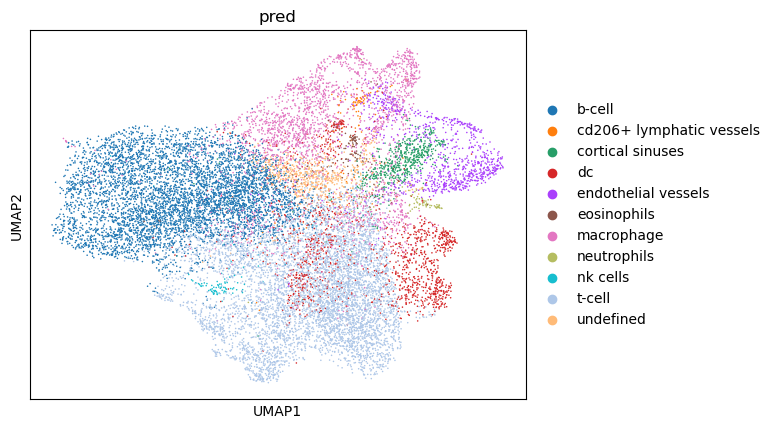

In [24]:
adata = anndata.AnnData(unlabeled_X)
results = np.load('../mouse_test/experiments/run/MouseLymphCross_STELLAR/MouseLymphCross_results__cross_epoch320_batch32_dist50_class14.npy')
results = results.astype('object')
for i in range(len(results)):
    if results[i] in inverse_dict.keys():
        results[i] = inverse_dict[results[i]]
adata.obs['pred'] = pd.Categorical(results)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['pred'], size=5)

In [25]:
inverse_dict


{0: 'b-cell',
 1: 'cd206+ lymphatic vessels',
 2: 'cortical sinuses',
 3: 'dc',
 4: 'endothelial vessels',
 5: 'eosinophils',
 6: 'macrophage',
 7: 'neutrophils',
 8: 'nk cells',
 9: 't-cell',
 10: 'undefined'}

In [26]:
see = np.vectorize(inverse_dict.get)(labeled_y)

In [27]:
unique, counts = np.unique(see, return_counts=True)

In [28]:
dict(zip(unique, counts))

{'b-cell': 3606,
 'cd206+ lymphatic vessels': 739,
 'cortical sinuses': 965,
 'dc': 2697,
 'endothelial vessels': 1427,
 'eosinophils': 492,
 'macrophage': 3201,
 'neutrophils': 253,
 'nk cells': 156,
 't-cell': 9332,
 'undefined': 676}

In [29]:
see = np.vectorize(inverse_dict.get)(test_y)
unique, counts = np.unique(see, return_counts=True)
dict(zip(unique, counts))

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set